In [1]:
import os, glob, math, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

2025-09-07 03:24:13.170700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757215453.377149      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757215453.430574      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Repro + runtime knobs

In [2]:
SEED = 1337
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.config.optimizer.set_jit(False)  # off XLA

try:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
except:
    pass

AUTOTUNE = tf.data.AUTOTUNE

### Paths + data loading

In [3]:
root = "/kaggle/input/140k-real-and-fake-faces"
candidates = [
    os.path.join(root, "real_vs_fake", "real-vs-fake"),
    os.path.join(root, "real-vs-fake"), 
]
base = next((p for p in candidates if os.path.isdir(p)), None)
assert base is not None, "Dataset path not found."

train_dir = os.path.join(base, "train")
valid_dir = os.path.join(base, "valid")
test_dir  = os.path.join(base, "test")

### Hyperparameters

In [4]:
IMG_SIZE   = 160
BATCH_SIZE = 16
EPOCHS     = 20
LABEL_SMOOTH = 0.05
WD = 1e-4
INIT_LR = 3e-4
DROPOUT = 0.40

### Datasets

In [5]:
def make_ds(dir_path, shuffle, batch_size=BATCH_SIZE):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="binary",
        class_names=["fake", "real"],  
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED,
    )
    return ds

train_ds = make_ds(train_dir, shuffle=True)
valid_ds = make_ds(valid_dir, shuffle=False)
test_ds  = make_ds(test_dir,  shuffle=False)

Found 100000 files belonging to 2 classes.


I0000 00:00:1757215635.497902      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [6]:
# Pipeline perf
def prep_for_perf(ds, training):
    opt = tf.data.Options()
    opt.experimental_deterministic = True
    ds = ds.with_options(opt)
    if training:
        ds = ds.shuffle(4 * BATCH_SIZE, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(1)         

train_ds = prep_for_perf(train_ds, training=True)
valid_ds = prep_for_perf(valid_ds, training=False)
test_ds  = prep_for_perf(test_ds,  training=False)

### Data augmentation + norm

In [7]:
augment = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.10),
        layers.RandomContrast(0.10),
    ],
    name="augment",
)
norm = layers.Rescaling(1.0 / 255.0)

### Model (custom CNN)

In [8]:
def se_block(x, ratio=8):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Reshape((1, 1, c))(s)
    s = layers.Dense(max(c // ratio, 4), activation="swish")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    return layers.Multiply()([x, s])

def conv_bn(x, f, k=3, s=1):
    x = layers.Conv2D(f, k, s, padding="same", use_bias=False, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    return x

def res_se_block(x, f, stride=1, se_ratio=0.25, drop=0.0):
    i = x
    x = conv_bn(x, f, 3, stride)
    x = layers.Conv2D(f, 3, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    if se_ratio:
        x = se_block(x, ratio=int(1 / se_ratio))
    if stride != 1 or i.shape[-1] != f:
        i = layers.Conv2D(f, 1, stride, padding="same", use_bias=False, kernel_initializer="he_normal")(i)
        i = layers.BatchNormalization()(i)
    x = layers.Add()([x, i])
    x = layers.Activation("swish")(x)
    if drop > 0:
        x = layers.Dropout(drop)(x)
    return x

def build_model():
    inp = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = augment(inp)
    x = norm(x)

    # Stem
    x = conv_bn(x, 32, 3, 2)        # 80x80
    x = conv_bn(x, 32, 3, 1)

    # Stages
    x = res_se_block(x, 64, 2, se_ratio=0.25, drop=0.0)   # 40x40
    x = res_se_block(x, 64, 1, se_ratio=0.25, drop=0.0)

    x = res_se_block(x, 128, 2, se_ratio=0.25, drop=0.05) # 20x20
    x = res_se_block(x, 128, 1, se_ratio=0.25, drop=0.05)

    x = res_se_block(x, 256, 2, se_ratio=0.25, drop=0.10) # 10x10
    x = res_se_block(x, 256, 1, se_ratio=0.25, drop=0.10)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(DROPOUT)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x) 
    return keras.Model(inp, out)

model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 160, 160,  │          0 │ cast[0][0]        │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 160, 160,  │          0 │ augment[0][0]     │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 40, 40,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 40, 40,    │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p

 Total params: 2,859,201 (10.91 MB)

 Trainable params: 2,854,593 (10.89 MB)

 Non-trainable params: 4,608 (18.00 KB)

### Optimizer, loss, metrics

In [9]:
try:
    opt = tf.keras.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WD)
except:
    opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)

bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTH)
metrics = [
    tf.keras.metrics.BinaryAccuracy(name="acc"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="prec"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=opt, loss=bce, metrics=metrics)

### Callbacks

In [ ]:
# Callbacks
ckpt_path = "/kaggle/working/best_cnn.weights.h5"  
cbs = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

### Train

In [11]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    verbose=1,
)

Epoch 1/20


E0000 00:00:1757215727.031708      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1757215732.209440      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.6337 - auc: 0.6858 - loss: 0.6412 - prec: 0.6311 - recall: 0.6181
Epoch 1: val_auc improved from -inf to 0.84836, saving model to /kaggle/working/best_cnn.weights.h5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 454s 68ms/step - acc: 0.6337 - auc: 0.6858 - loss: 0.6412 - prec: 0.6311 - recall: 0.6181 - val_acc: 0.7219 - val_auc: 0.8484 - val_loss: 0.5879 - val_prec: 0.6572 - val_recall: 0.9278 - learning_rate: 3.0000e-04
Epoch 2/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.7920 - auc: 0.8726 - loss: 0.4764 - prec: 0.7891 - recall: 0.7915
Epoch 2: val_auc improved from 0.84836 to 0.93299, saving model to /kaggle/working/best_cnn.weights.h5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 405s 65ms/step - acc: 0.7920 - auc: 0.8726 - loss: 0.4764 - prec: 0.7891 - recall: 0.7915 - val_acc: 0.8561 - val_auc: 0.9330 - val_loss: 0.3812 - val_prec: 0.8405 - val_recall: 0.8789 - learning_rate: 3.0000e-04
Epoch 3/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc

In [12]:
model.save("/kaggle/working/real_vs_fake_cnn.keras")  # save model
print("\nSaved: /kaggle/working/real_vs_fake_cnn_tf and best weights:", ckpt_path)


Saved: /kaggle/working/real_vs_fake_cnn_tf and best weights: /kaggle/working/best_cnn.weights.h5


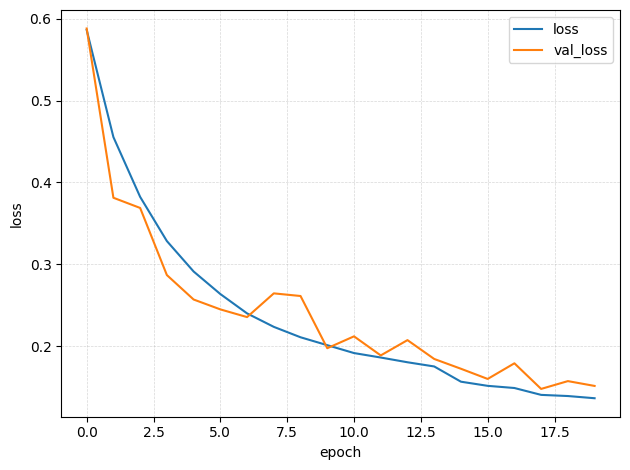

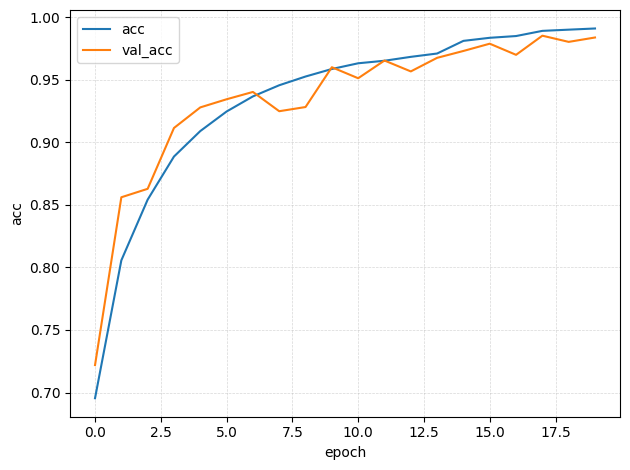

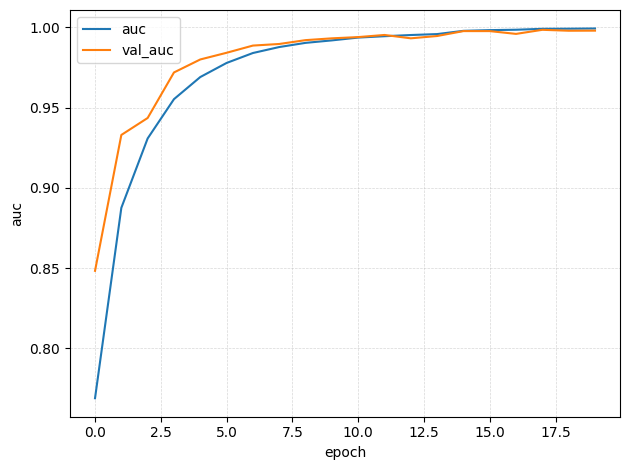

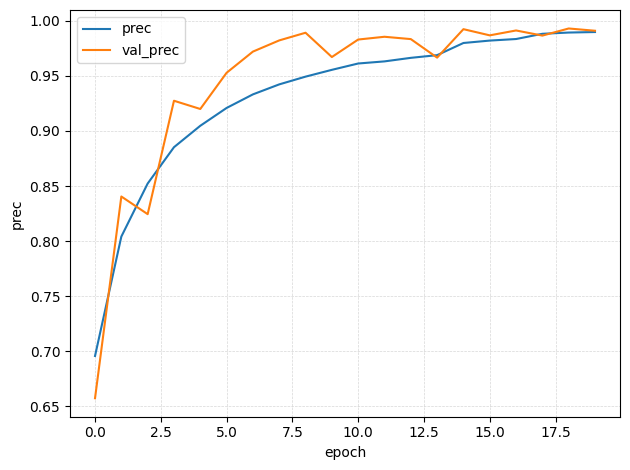

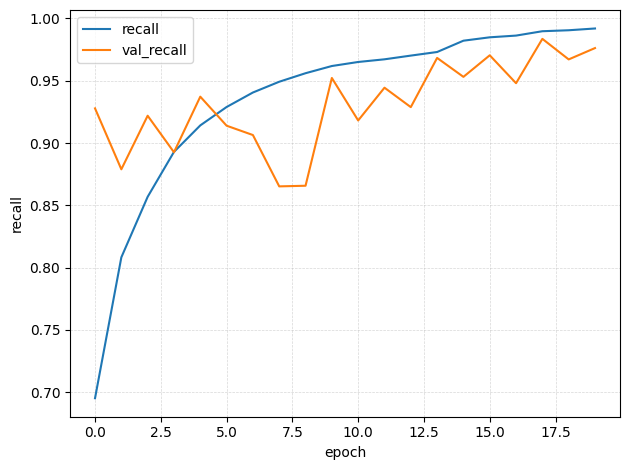

Saved: /kaggle/working/figs/*.png, /kaggle/working/history.csv


In [13]:
import os, matplotlib.pyplot as plt, pandas as pd

hist = history.history
os.makedirs("/kaggle/working/figs", exist_ok=True)

def plot_metric(m):
    if m not in hist: 
        print(f"skip {m}"); 
        return
    plt.figure()
    plt.plot(hist[m], label=m)
    vm = f"val_{m}"
    if vm in hist:
        plt.plot(hist[vm], label=vm)
    plt.xlabel("epoch"); plt.ylabel(m); plt.legend(); plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    out = f"/kaggle/working/figs/{m}.png"
    plt.savefig(out, dpi=150)
    plt.show()

for m in ["loss","acc","auc","prec","recall"]:
    plot_metric(m)

pd.DataFrame(hist).to_csv("/kaggle/working/history.csv", index=False)
print("Saved: /kaggle/working/figs/*.png, /kaggle/working/history.csv")

### Eval on valid + test

In [14]:
def eval_ds(model, ds, name="split"):
    y_true = []
    y_prob = []
    for xb, yb in ds:
        p = model.predict(xb, verbose=0).ravel()
        y_prob.append(p)
        y_true.append(yb.numpy().ravel())
    y_prob = np.concatenate(y_prob)
    y_true = np.concatenate(y_true)
    y_pred = (y_prob >= 0.5).astype(np.int32)

    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = float("nan")
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name} | acc={acc:.4f} auc={auc:.4f}")
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true, y_pred, target_names=["fake","real"]))
    return acc, auc, cm

print("\n== Test ==")
test_acc, test_auc, _ = eval_ds(model, test_ds, name="test")


== Test ==


2025-09-07 05:49:22.634172: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-07 05:49:27.709678: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


test | acc=0.9849 auc=0.9985
Confusion matrix:
 [[9866  134]
 [ 167 9833]]

Report:
               precision    recall  f1-score   support

        fake       0.98      0.99      0.98     10000
        real       0.99      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

